In [163]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Algorithm

1. Initial clustering and merging:
    * identifies clusters based on spatio-temporal nearness
        * events must first be close in time $\to$ identifies many small clusters
        * adding a new event must be close to the statistical center of a cluster
    * adjacent clusters are merged when they not sufficiently separated 

2. Remaining clusters are 
```
clusters_1 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
clusters_2 = get_extended_clusters(time_arr, noise_arr, clusters_1, time_thresh)
clusters_3 = separate_embedded_clusters(clusters_2, True)
clusters_4 = merge_clusters_combo(time_arr, noise_arr, clusters_3, dist_thresh, time_thresh)
clusters_4 = sorted([sorted(c) for c in clusters_4])
clusters_5 = get_iqr_trimmed_clusters(noise_arr, clusters_4, 1.5);
```

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos


* check that the newly split clusters are 
    * contain enough samples
    * $\checkmark$ ~~have a total duration longer than the threshold~~ see `get_extended_clusters`
    * $\checkmark$ ~~are not embedded within another cluster~~ possible, but unused; see `separate_embedded_clusters`
* $\checkmark$ ~~check that there are no embedded clusters~~ see `separate_embedded_clusters`
    * ~~times don't overlap~~ $\checkmark\to$ have function
    * ~~if refined clusters are embedded, check if one cluster is noise~~ ignored
* check the stddev of the refined clusters are smaller
* check on adjacent clusters
    * $\checkmark$ ~~check on the limits of time between adjacent clusters, esp. when they have the same mean and/or median~~ see `merge_clusters_combo`
        * if at $x_a$ for $t_1$ then again at $x_a$ for $t_2$, duration between going from and back to $x_a$ should reflect some mimimal amount of time ($2\times$ travel and a stay), 
            * e.g. 
                * from $x_a$ to an unknown $x_b$ with a stay at $x_b$ of the miminum duration and then back to $x_a$ 
                * should satisfy some criterion or _there is no inbetween travel and $t_1$ and $t_2$ are part of the same cluster_
    * $\checkmark$ ~~check of the metrics for inter-subcluster gaps~~ see `merge_clusters_combo`
        * these are also clusters but unlabeled after the first round of clustering
    * **!!!** check that the identified stays during the substages are not immediately adjacent
        * _ie_ no stays should have indices like `[10, ..., 20]` followed by `[21, ..., 30]`
            * such stays are possible $\to$ but there should be a minimum travel time if the locations are distinct
## Notes: 

* **Gaps** 
    * since there are subclusters for a given cluster which are separated by gaps, these gaps ...

### 1-stay
* gap-merging works well when good density; poorly when otherwise

## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.



In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Clustering

## Split the clusters which have a temporal gap

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

### From here

At this point, it seems that the basic clusters are formed. 

Next, use the IQRs of these clusters as the new bounds for extending the cluster: essentially using the extensible box method.

Note that the IQR can be larger than the allow distance threshold; the box would therefore need to be the smaller of the two but with the same mean and/or median

### Summary

1. `get_clusters_x` finds the clusters based on nearness of events in space and time
2. `merge_clusters` merges neraby clusters based on ...
3. `merge_clusters_2`  merges neraby clusters based on ...
4. `extend_clusters` extend the clusters
5. `separate_clusters` break the overlapping clusters and then re-merge
6. `merge_clusters_2` merge the separated clusters
7. `intersect` the forward and backward clusters

In [8]:
from helper__3stays_v3_scripts import switch_indices

In [165]:
from synthetic_data.plotting import plot_trajectory, add_plot_trajectory, add_plot_seg_boxes

In [169]:
from helper__3stays_v3_scripts__plotting import plot_cluster_boxplots, add_plot_cluster_boxplots

In [10]:
from helper__3stays_v3_scripts__eval import get_segments_scores

In [11]:
print_clusts = lambda cluster_list : [print(f"[{c[0]:4d},{c[-1]:4d}]") for c in cluster_list]
#print_ctimes = lambda cluster_list : [print(f"[{time_arr[c[0]]:6.3f},{time_arr[c[-1]]:6.3f}]") for c in cluster_list]
#print_ctdiff = lambda cluster_list : [print(f"{time_arr[c[-1]] - time_arr[c[0]]:6.3f}") for c in cluster_list]
#print_times = lambda l: list(map(lambda x: f"{x:6.3f}",l))

# Start here

In [12]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
#from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
#from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [13]:
from synthetic_data.canonical_stays import get3e, get3

In [14]:
from helper__get_clusters import get_clusters_1, get_clusters_2, get_clusters_3, get_clusters_4

In [15]:
time_thresh = 1/6
dist_thresh=0.25

In [16]:
rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_

event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.30 #rand_range(1,0.3,0.05)[0]

print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

In [546]:
event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.30 #rand_range(1,0.3,0.05)[0]

print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

Event frac. =  0.007
Dupli. frac. =  0.300


2.9048392598842514 7.620448033973139 0.594514151591147
[0] False


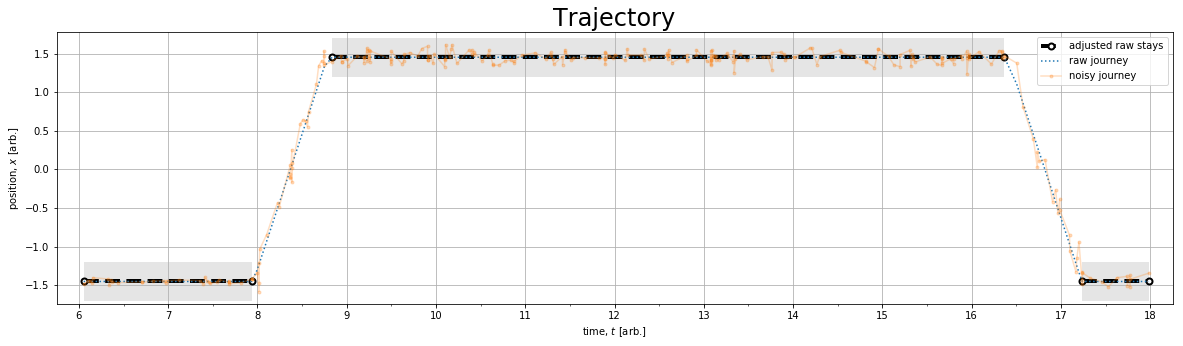

In [547]:
x_dist = rand_range(0.52,5.0, 10)[0]
mid_len = rand_range(0.2, 8, 10)[0]
shift = rand_range(-5, 5, 21)[0]

print(x_dist, mid_len, shift)
val = np.random.randint(0,2,1)
print(val, bool(val))
if val:
    stays = get3(x_dist, mid_len, shift)
else:
    stays = get3e(x_dist, mid_len, shift)    

continuation = True
n = 0
while continuation:
    try:
        time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
        continuation = False
    except:
        print("Failed")
        if n > 10: 
            continuation = False
        else:
            n+=1
        pass
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_xlim([5.75,18.25]);

In [78]:
from helper__3stays_v3_scripts import get_extended_clusters, separate_clusters
from helper__gaps import merge_clusters_combo
from helper__metric_box__explore import eval_synth_data

In [20]:
def split_list( l1, l2): 
    
    """
    Usage:
    split_list(range(10), list(range(4,7)))
    ([0, 1, 2, 3], [4, 5, 6], [7, 8, 9])
    """
    
    if len(l1) < len(l2):
        return ([e for e in l2 if e < min(l1)], l1, [e for e in l2 if e > max(l1)])
    else:
        return ([e for e in l1 if e < min(l2)], l2, [e for e in l1 if e > max(l2)])        

def list_intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 


def contains(a1,a2,b1,b2):
    """
    Check whether one range contains another
    """    
    return ((a1 >= b1) & (a2 <= b2))

inter_bounds = lambda p1, p2: intersecting_bounds(p1[0],p1[-1],p2[0],p2[-1])
conta_bounds = lambda p1, p2: contains(p1[0],p1[-1],p2[0],p2[-1])

def intersecting_bounds(a1,a2,b1,b2):
    """
    Check whether two ranges intersect
    
    Specifically: b1 < a1 < b2 and a2 > b2
    """

    cond1 = ((a1 >= b1) & (a1 <= b2)) | \
            ((b1 >= a1) & (b1 <= a2))    
    
    return cond1

'''
def intersecting_bounds(a1,a2,b1,b2):
    """
    Check whether two ranges intersect
    
    Specifically: b1 < a1 < b2 and a2 > b2
    """
    print(a1,a2,b1,b2)
    
    print((a1 >  b1), (a1 <= b2), (a2 >= b2))
    print((a1 >= b1), (a1 <  b2), (a2 >  b2))
    
    cond1 = (((a1 >  b1) & (a1 < b2)) & (a2 > b2)) | \
             (((a1 > b1) & (a1 < b2)) & (a2 > b2))
    return cond1
'''

def get_sorted_keys(clusts):
    d = {}
    for n, c in enumerate(clusts):
        d[n] = len(c)

    return [k for k, v in sorted(d.items(), key=lambda item: item[1])]

def check_intersecting_clusters_inds(clusters):
    m = 0
    while (m < len(clusters)):
        # Biggest cluster
        c1 = clusters[m]
        n = m+1
        while (n < len(clusters)):

            if n == m:
                n+=1
                continue

            c2 = clusters[n]
            if inter_bounds(c1,c2):
                return True, m,n
            else:
                n+=1
        m+=1
    return False, 999, 999

def check_intersecting_clusters(clusters):
    
    result, _ , _ = check_intersecting_clusters_inds(clusters)
 
    return result

def separate_clusters_hier(clusters, verbose=False):
    """
    
    Test:
    clusts = [list(range(2,4)), list(range(8)), list(range(4,8)), list(range(6,10))]
    separate_clusters_hier(clusts)
    [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
    """    
    # Check if any clusters intersect
    new_clusts = clusters.copy()
    
    result, m, n = check_intersecting_clusters_inds(new_clusts)
    
    if verbose: print(result)    
    
    if result:
        if verbose: print(m, n)
    else:
        return clusters

    while result:
        
        if verbose: print_clusts(new_clusts)
        if verbose: print(len(new_clusts))
        c1 = new_clusts.pop(m)
        if m < n: 
            n-=1
        c2 = new_clusts.pop(n)

        if verbose: print(len(new_clusts))
        if verbose: print(f"{m:4d}: [{c1[0]:4d},{c1[-1]:4d}] and [{c2[0]:4d},{c2[-1]:4d}]")

        '''sc1 = set(c1)
        sc2 = set(c2)

        intersexion = sc1.intersection(sc2)

        sc1_diff = sc1.difference(intersexion)
        sc2_diff = sc2.difference(intersexion)                
        '''
        
        sc1_diff, intersec, sc2_diff = split_list(c1,c2)        
        
        #sc1_diff = list(sc1_diff)
        if len(sc1_diff) > 0:
            new_clusts.append(sc1_diff)
        if verbose: print("len(sc1_diff)",len(sc1_diff))
        
        #intersexion = list(intersexion)
        if len(intersec) > 0:
            new_clusts.append(intersec)
        if verbose: print("len(intersexion)",len(intersec))
        
        #sc2_diff = list(sc2_diff)
        if len(sc2_diff) > 0:
            new_clusts.append(sc2_diff)
        if verbose: print("len(sc2_diff)",len(sc2_diff))
        
        if verbose: print(len(new_clusts))
        if verbose: print_clusts(new_clusts) 
        
        result, m, n = check_intersecting_clusters_inds(new_clusts)
        if verbose: print(result,m,n)
        if verbose: print()
        
    return new_clusts

In [21]:
from helper__metric_box__explore import get_iqr_mask

In [24]:
def contiguous_sublists(lst1, lst2): 
    """
    Split intersecting and interleaved lists 
    into maximal contiguous sublists
    """
    #print(lst1, lst2)
    # Gather all unique elements together and order
    lst3 = sorted(list(set(lst1+lst2)))

    # Classifying function according to origin and intersections
    def get_flag(e):
        if (e in lst1) & (e in lst2):
            return 0
        elif (e in lst1):
            return 1
        else:
            return 2
    
    # output list
    all_lists = []
    
    # Initializations
    e = lst3[0]    
    flag = get_flag(e)
    lst = [e]
    
    # Walk through all elements
    for e in lst3[1:]:
        flag_ = get_flag(e)
        
        if flag == flag_:
            lst.append(e)
        else:
            all_lists.append(lst)
            lst = [e]
            flag = flag_
    
    # close the last list
    all_lists.append(lst)        
    
    # Sort the lists (maybe unnecessary)
    #all_lists = sorted([l for l in all_lists if l != []])
    
    return all_lists    

In [25]:
def separate_embedded_clusters(clusters, verbose=False):
    """
    
    Test:
    clusts = [list(range(5)), list(range(2,4)), list(range(8)), list(range(4,8)), list(range(6,10))]
    separate_embedded_clusters(clusts)
    [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
    """    
    # Check if any clusters intersect
    new_clusts = clusters.copy()
    
    result, m, n = check_intersecting_clusters_inds(new_clusts)
    
    if verbose: print(result)    
    
    if result:
        if verbose: print(m, n)
    else:
        return clusters

    while result:
        
        #if verbose: print_clusts(new_clusts)
        if verbose: print(len(new_clusts))
        c1 = new_clusts.pop(m)
        if m < n: 
            n-=1
        c2 = new_clusts.pop(n)

        if verbose: print(len(new_clusts))
        if verbose: print(f"{m:4d}: [{c1[0]:4d},{c1[-1]:4d}] and [{c2[0]:4d},{c2[-1]:4d}]")

        '''sc1 = set(c1)
        sc2 = set(c2)

        intersexion = sc1.intersection(sc2)

        sc1_diff = sc1.difference(intersexion)
        sc2_diff = sc2.difference(intersexion)                
        '''
        
        new_clusts.extend(contiguous_sublists(c1, c2))
        '''        
        sc1_diff, intersec, sc2_diff = split_list(c1,c2)        
        
        #sc1_diff = list(sc1_diff)
        if len(sc1_diff) > 0:
            new_clusts.append(sc1_diff)
        if verbose: print("len(sc1_diff)",len(sc1_diff))
        
        #intersexion = list(intersexion)
        if len(intersec) > 0:
            new_clusts.append(intersec)
        if verbose: print("len(intersexion)",len(intersec))
        
        #sc2_diff = list(sc2_diff)
        if len(sc2_diff) > 0:
            new_clusts.append(sc2_diff)
        if verbose: print("len(sc2_diff)",len(sc2_diff))
        '''
        if verbose: print(len(new_clusts))
        #if verbose: print_clusts(new_clusts) 
        
        result, m, n = check_intersecting_clusters_inds(new_clusts)
        if verbose: print(result,m,n)
        if verbose: print()

    return sorted(new_clusts)            

In [26]:
def get_iqr_trimmed_clusters(x_arr, clusters, iqr_factor=1.5, within=True, verbose=False):
    new_clusters = []
    for c in clusters:
        cc = get_iqr_mask(x_arr[c], c, iqr_factor, within)[0]
        
        ccc = list(range(cc[0], cc[-1]+1))
        
        if verbose: print(f"[{c[0]:4d},{c[-1]:4d}] vs. [{cc[0]:4d},{cc[-1]:4d}]")
        #f" vs. [{ccc[0]:4d},{ccc[-1]:4d}]" )

        new_clusters.append(ccc)
        
    return new_clusters

Event frac. =  0.003
Dupli. frac. =  0.300
 1.300,  6.556, -3.379
[1] True
Failed
Failed
Stage 1
3 Clusters:
[   0,   7]
[   8,  74]
[  76, 129]

Stage 2
3 Clusters:
[   0,   7]
[   5,  74]
[  75, 129]

Stage 3
True
0 1
3
1
   0: [   0,   7] and [   5,  74]
4
False 999 999

4 Clusters:
[   0,   4]
[   5,   7]
[   8,  74]
[  75, 129]

Stage 4
3 Clusters:
[   0,   7]
[   8,  74]
[  75, 129]

Stage 5
3 Clusters:
[   0,   7]
[   8,  74]
[  75, 129]

Predicted 3 of 3 true clusters 
	Cluster   0, [   0,   4]
		overlaps with 1 pred_cluster(s):
			[   0,   7]
			precision:  0.625;
			recall:  1.000

	Cluster   1, [   7,  74]
		overlaps with 2 pred_cluster(s):
			[   0,   7]
			[   8,  74]
			precision:  1.000;
			recall:  0.985

	Cluster   2, [  75, 129]
		overlaps with 1 pred_cluster(s):
			[  75, 129]
			precision:  1.000;
			recall:  1.000

Stats: 
	min. precision:  0.125; min. recall:  0.015
	avg. precision:  0.688; avg. recall:  0.750
	tot. precision:  0.985; tot. recall:  1.000

Duration

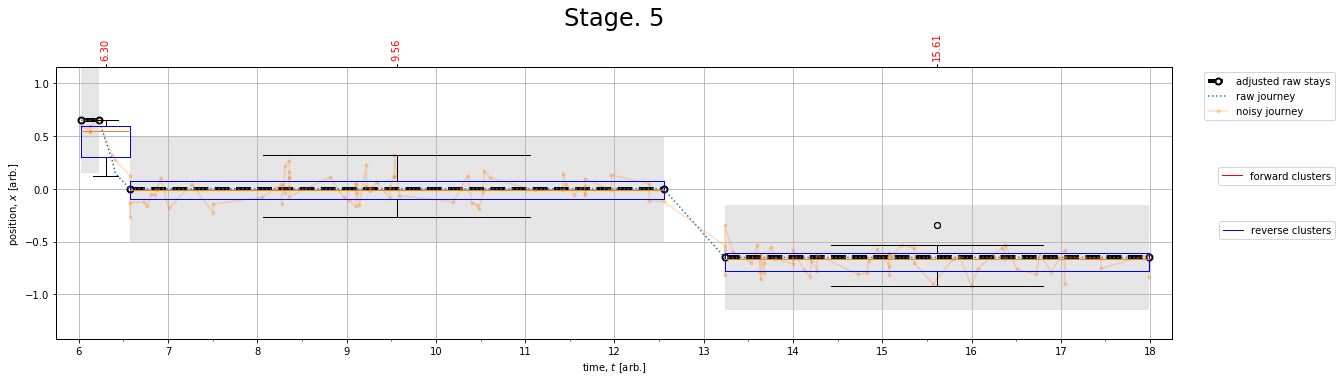

In [548]:
event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.30 #rand_range(1,0.3,0.05)[0]

print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}
x_dist = rand_range(0.52,5.0, 10)[0]
mid_len = rand_range(0.2, 8, 10)[0]
shift = rand_range(-5, 5, 21)[0]

print(f"{x_dist:6.3f}, {mid_len:6.3f}, {shift:6.3f}")
val = np.random.randint(0,2,1)
print(val, bool(val))
if val:
    stays = get3(x_dist, mid_len, shift)
else:
    stays = get3e(x_dist, mid_len, shift)    

continuation = True
n = 0
while continuation:
    try:
        time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
        continuation = False
    except:
        print("Failed")
        if n > 10: 
            continuation = False
        else:
            n+=1
        pass

t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

verbose = True

if verbose: print("Stage 1")
clusters_1 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
print(len(clusters_1), "Clusters:")
print_clusts(clusters_1);
print()

if verbose: print("Stage 2")
clusters_2 = get_extended_clusters(time_arr, noise_arr, clusters_1, time_thresh)
print(len(clusters_2), "Clusters:")
print_clusts(clusters_2);
print()

if verbose: print("Stage 3")
#clusters_3 = separate_clusters_hier(clusters_2, True)
if clusters_2 != clusters_1:
    clusters_3 = separate_embedded_clusters(clusters_2, True)
    print(len(clusters_3), "Clusters:")
    print_clusts(clusters_3);
else: 
    print("No update")    
    clusters_3 = clusters_2.copy()
print()    
    
if verbose: print("Stage 4")
if clusters_3 != clusters_2:    
    clusters_4 = merge_clusters_combo(time_arr, noise_arr, clusters_3, dist_thresh, time_thresh)
    print(len(clusters_4), "Clusters:")
    print_clusts(clusters_4);    
else: 
    print("No update")
    clusters_4 = clusters_3.copy()
print()

if verbose: print("Stage 5")
clusters_4 = sorted([sorted(c) for c in clusters_4])
iqr_trim = True
if iqr_trim:        
    clusters_5 = get_iqr_trimmed_clusters(noise_arr, clusters_4, 1.5);
    print(len(clusters_5), "Clusters:")
    print_clusts(clusters_5);
else: 
    print("No IQR-trim")
    clusters_5 = clusters_4.copy()
print()

get_segments_scores(time_arr, segments, clusters_5, True)

ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_5, switch_indices(clusters_5, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 5", fontsize=24);

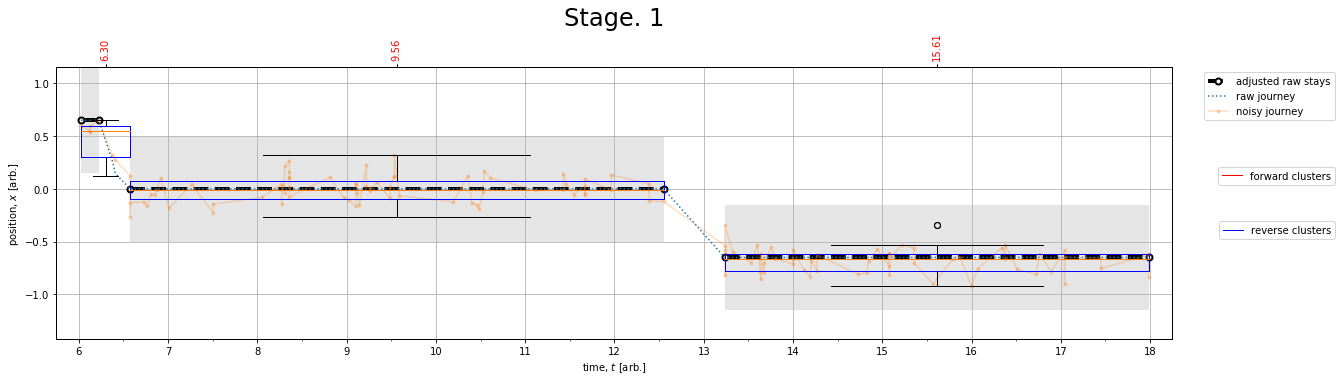

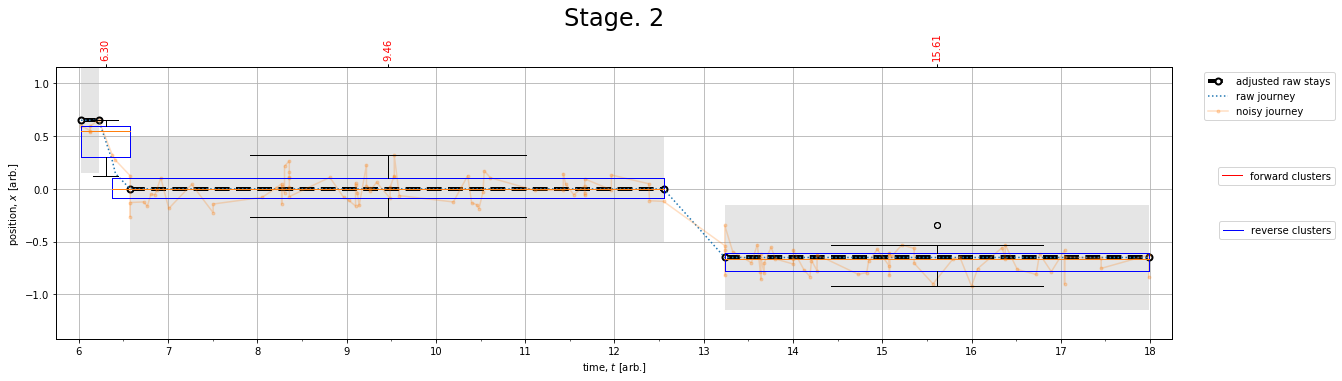

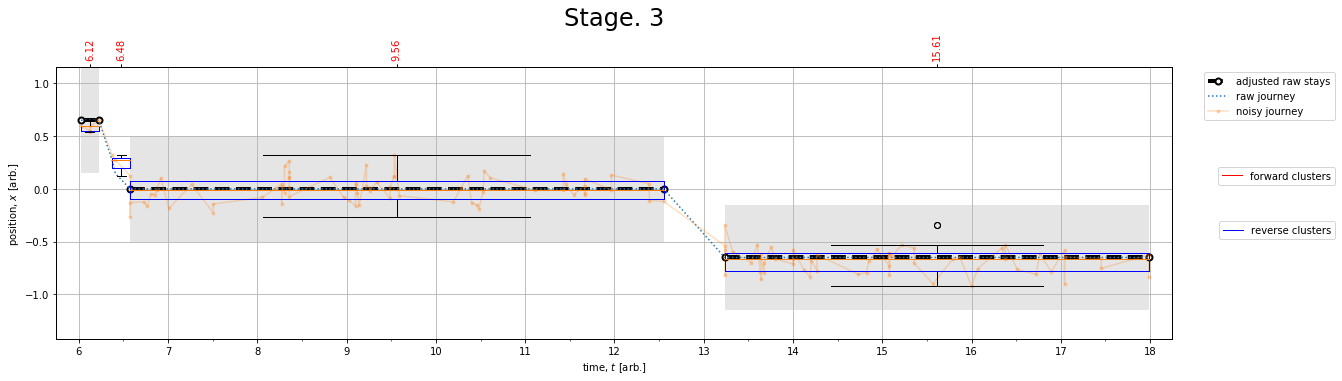

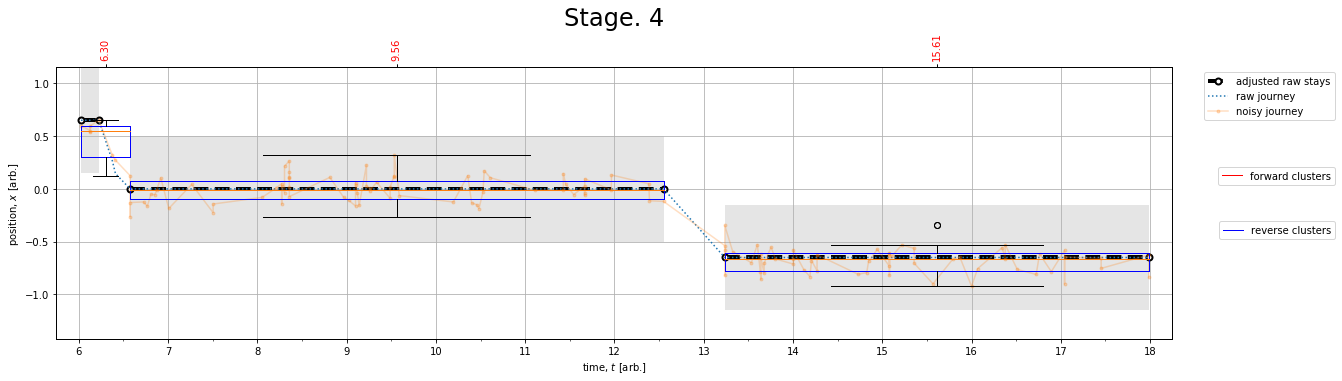

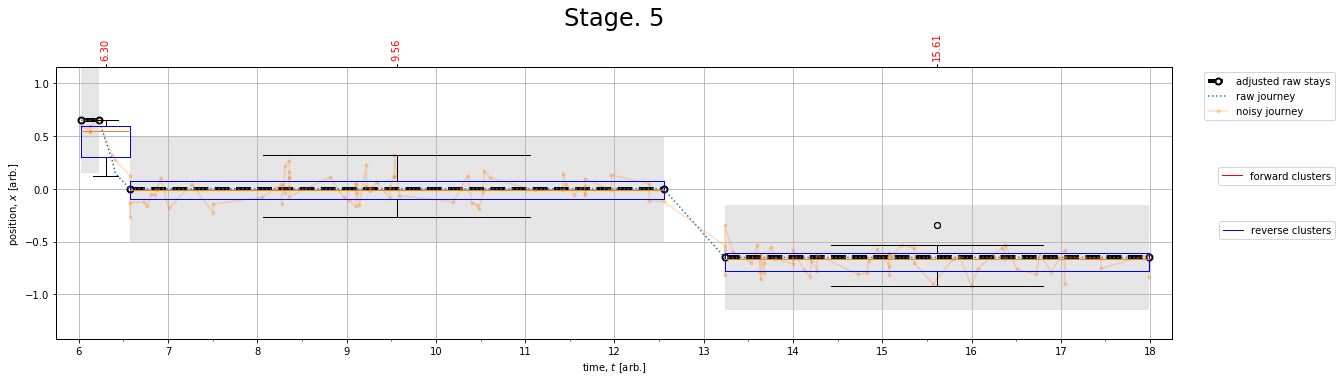

In [549]:
ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]


ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_1, switch_indices(clusters_1, time_arr.shape[0]), configs)
ax.set_ylim(ylim);
ax.set_title("Stage. 1", fontsize=24)

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_2, switch_indices(clusters_2, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 2", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_3, switch_indices(clusters_3, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 3", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_4, switch_indices(clusters_4, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 4", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_5, switch_indices(clusters_5, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 5", fontsize=24);


### Notes
#### 3 clusters
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
* missing short clusters
    * these usually occur on the edges
    * if using a IQR-postfilter, many of these will get dropped
    
#### 4 clusters
* mis-identified cluster, aka "floater"
    * part of a travel
        * in the canonical 3-stays, these are always between larger stays
        * **Todo** 
            * _check if these have insufficient events with the IQR-mask_
            * _check if these have insufficient duration with the IQR-mask_            
    * seems to be short in duration
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
    * missing short clusters and overlaps/duplicates

In [550]:
from synthetic_data.trajectory_class import pickle_trajectory
from datetime import datetime

import os

date_tag = datetime.today().strftime('%Y%m%d')
data_dir = f"./testdata_{date_tag}_1/"

try:
    os.makedirs(data_dir)
except OSError as e:
    print(e)

In [551]:
lens = []
precs = []
recs = []

width=6

total = width*width*(2*width+1)
print(total)


precrec_limit = 0.80

i = 0

length_criterion_break = False
iqr_trim = False
verbose = False

index = 0
for x_dist in rand_range(2.05*dist_thresh,11.0, width):
    for mid_len in rand_range(0.2, 10, width):
        for shift in rand_range(-5, 5, 2*width+1):
            
            event_frac = rand_range(0.01,0.001, 1)[0]
            duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

            if verbose: print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

            configs = {
                'time_thresh':1/6,
                'dist_thresh':0.5,
                'event_frac':event_frac,
                'duplicate_frac':duplicate_frac,    
                'noise_min':0.02,
                'noise_max':0.15
            }            
            
            if verbose: print(f"{x_dist:6.3f}, {mid_len:6.3f}, {shift:6.3f}")
            
            val = np.random.randint(0,2,1)
            if val:
                stays = get3(x_dist, mid_len, shift)
            else:
                stays = get3e(x_dist, mid_len, shift)            
            
            continuation = True
            m = 0
            while continuation:
                n = 0
                try:
                    time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
                    t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))
                    continuation = False
                except:
                    print("Failed at",m,n)
                    if n > 10: 
                        continuation = False
                    else:
                        n+=1
                    pass

                try:

                    if verbose: print("Stage 1")
                    clusters_1 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
                    if verbose: print(len(clusters_1), "Clusters:")
                    if verbose: print_clusts(clusters_1);
                    if verbose: print()

                    if verbose: print("Stage 2")
                    clusters_2 = get_extended_clusters(time_arr, noise_arr, clusters_1, time_thresh)
                    if verbose: print(len(clusters_2), "Clusters:")
                    if verbose: print_clusts(clusters_2);
                    if verbose: print()

                    if verbose: print("Stage 3")
                    #clusters_3 = separate_clusters_hier(clusters_2, True)
                    if clusters_2 != clusters_1:
                        clusters_3 = separate_embedded_clusters(clusters_2)
                        if verbose: print(len(clusters_3), "Clusters:")
                        if verbose: print_clusts(clusters_3);
                    else: 
                        if verbose: print("No update")    
                        clusters_3 = clusters_2.copy()
                    if verbose: print()  
                        
                    #NOTE: at this point, later stages are ignored
                    clusters_3 = clusters_2.copy()
                    
                    if verbose: print("Stage 4")
                    if clusters_3 != clusters_2:    
                        clusters_4 = merge_clusters_combo(time_arr, noise_arr, clusters_3, dist_thresh, time_thresh)
                        if verbose: print(len(clusters_4), "Clusters:")
                        if verbose: print_clusts(clusters_4);    
                    else: 
                        if verbose: print("No update")
                        clusters_4 = clusters_3.copy()
                    if verbose: print()

                    if verbose: print("Stage 5")
                    clusters_4 = sorted([sorted(c) for c in clusters_4])
                    
                    if iqr_trim:        
                        clusters_5 = get_iqr_trimmed_clusters(noise_arr, clusters_4, 1.5);
                        if verbose: print(len(clusters_5), "Clusters:")
                        if verbose: print_clusts(clusters_5);
                    else: 
                        if verbose: print("No IQR-trim")
                        clusters_5 = clusters_4.copy()
                    if verbose: print()

                    continuation = False
                except:                    
                    print("Failed at",m)
                    print(stays)                    
                    if m > 10: 
                        break
                    else:
                        m+=1
                    pass
                
                prec, rec, conmat = eval_synth_data(segments, time_arr, clusters_5)
                
                if (prec < precrec_limit) | (rec < precrec_limit):
                    if (prec < precrec_limit) & (rec < precrec_limit):
                        print("p&r low")
                    elif (prec < precrec_limit):
                        print("p low")
                    else:
                        print("r low")
                    
                    all_clusters = [
                        clusters_1,
                        clusters_2,
                        clusters_3,
                        clusters_4,
                        clusters_5    
                    ]

                    fig, axs = plt.subplots(5,1,figsize=[20,30])

                    ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]

                    axs =axs.flatten()

                    for i in range(5):
                        try:
                            ax = axs[i]
                            add_plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, all_clusters[i], switch_indices(all_clusters[i], time_arr.shape[0]), configs, ax)
                            ax.set_ylim(ylim);
                            ax.set_title(f"Stage. {i}", fontsize=24)
                        except:
                            pass

                    fig.suptitle(f"prec. {prec:6.3f}, {rec:6.3f}", fontsize=16)

                    precstr = f"{prec:6.3f}".strip().replace(".","o")
                    recstr = f"{rec:6.3f}".strip().replace(".","o")

                    stays_tag = int((x_segs.size)/3)
                    notes = f"prec{precstr}_rec{recstr}"

                    trajectory_tag = f"trajectory_{stays_tag}stays__{notes}"
                    path_to_file =  data_dir + trajectory_tag
                    pickle_trajectory(time_arr, raw_arr, noise_arr, segments, path_to_file + ".pkl")
                    
                    plt.savefig(path_to_file + ".png")
                    plt.close()
                    
                    #break
                    
                lens.append(len(clusters_5))
                precs.append(prec)
                recs.append(rec)
                
            if i % (width*width) == 0:
                print(f"{i:4d} of {total:5d}")
            i+=1

            if length_criterion_break: break
        if length_criterion_break: break
    if length_criterion_break: break
    
    index += 1
    
#print_clusts(clusters_5);

468
Failed at 0 0
   0 of   468
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
p low
p low
Failed at 0 0
p low
Failed at 0 0
p low
p low
p low
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
p low
p low
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
p low
p low
p low
p low
p low
p low
p low
p low
p low
Failed at 0 0
p low
Failed at 0 0
p low
p low
p low
p low
Failed at 0 0
Failed at 0 0
Failed at 0 0
  36 of   468
Failed at 0 0
p low
Failed at 0 0
p low
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
  36 of   468
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
p low
Failed

In [552]:
print(len(precs),len(recs))

468 468


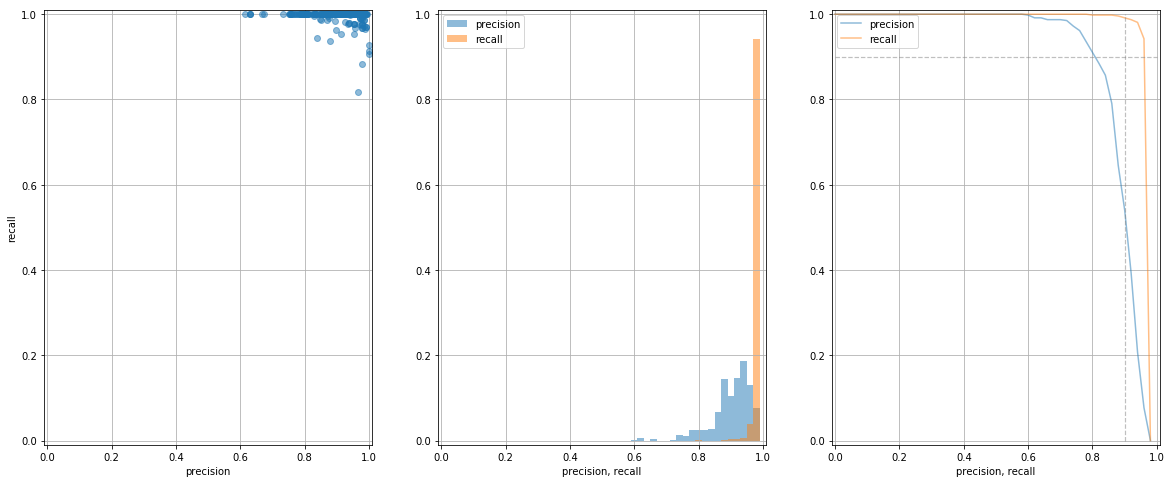

In [553]:
fig, axs = plt.subplots(1,3, figsize=[20,8])
axs = axs.flatten()
ax =axs[0]
ax.plot(precs, recs, 'o', alpha=0.5)
lims=[-.01,1.01]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("precision")
ax.set_ylabel("recall")
ax.grid()

binw=0.02
bins=np.arange(0.0,1.0+binw,binw)
hp, _ = np.histogram(np.array(precs), bins=bins, density=True)
hr, _ = np.histogram(np.array( recs), bins=bins, density=True)

ax = axs[1]
_ = ax.bar(bins[:-1], hp*binw, alpha=0.5, width=binw, align='center', label="precision")
_ = ax.bar(bins[:-1], hr*binw, alpha=0.5, width=binw, align='center', label="recall")
ax.set_xlabel("precision, recall")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.grid()
ax.legend();

ax = axs[2]
_ = ax.plot(bins[:-1], 1-np.cumsum(hp*binw), alpha=0.5,label="precision")
_ = ax.plot(bins[:-1], 1-np.cumsum(hr*binw), alpha=0.5,label="recall")
ax.plot([0.9,0.9],[0,1], '--', color='gray', lw=1.2, alpha=0.5)
ax.plot([0,1],[0.9,0.9], '--', color='gray', lw=1.2, alpha=0.5)
ax.set_xlabel("precision, recall")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.grid()
ax.legend()
fig.savefig(data_dir + "metrics.png")

## Revisit some bad files

In [555]:
!ls testdata_20200816_1/*.pkl #| wc -l

testdata_20200816_1/trajectory_3stays__prec0o615_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o629_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o630_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o667_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o673_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o733_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o752_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o755_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o756_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o759_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o761_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o765_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o766_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o772_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o775_rec1o000.pkl
testdata_20200816_1/trajectory_3stays__prec0o781_rec1o000.pkl
testdata

In [453]:
!ls testdata_20200815_3/*.pkl

testdata_20200815_3/trajectory_3stays__prec0o664_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o684_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o689_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o698_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o709_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o724_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o742_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o746_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o750_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o753_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o766_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o776_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o781_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o782_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o783_rec1o000.pkl
testdata_20200815_3/trajectory_3stays__prec0o789_rec1o000.pkl
testdata

In [214]:
import pickle

In [556]:
trajectory = pickle.load( open(data_dir + "trajectory_3stays__prec0o615_rec1o000.pkl", "rb") )

In [557]:
segments = trajectory['segments']
t_arr = trajectory['time_arr']
r_arr = trajectory['raw_locs_arr']
x_arr = trajectory['nse_locs_arr']

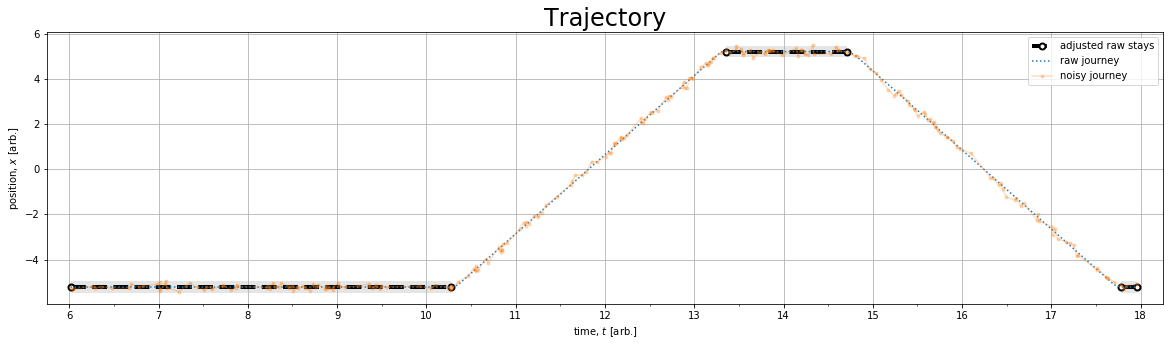

In [569]:
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

ax = plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_xlim([5.75,18.25]);

Stage 1
24 Clusters:
[   0,  75]
[  77,  83]
[  84,  90]
[  92,  99]
[ 102, 106]
[ 107, 109]
[ 110, 119]
[ 120, 126]
[ 127, 130]
[ 133, 137]
[ 138, 146]
[ 147, 180]
[ 181, 182]
[ 185, 190]
[ 191, 201]
[ 202, 205]
[ 207, 209]
[ 212, 214]
[ 215, 219]
[ 220, 222]
[ 226, 229]
[ 230, 231]
[ 234, 237]
[ 238, 241]

Stage 2
12 Clusters:
[   0,  75]
[  92,  99]
[ 102, 106]
[ 110, 119]
[ 120, 126]
[ 138, 180]
[ 144, 180]
[ 185, 190]
[ 191, 201]
[ 215, 219]
[ 226, 229]
[ 238, 241]

Stage 3
11 Clusters:
[   0,  75]
[  92,  99]
[ 102, 106]
[ 110, 119]
[ 120, 126]
[ 185, 190]
[ 191, 201]
[ 215, 219]
[ 226, 229]
[ 238, 241]
[ 138, 180]

Stage 4
11 Clusters:
[   0,  75]
[  92,  99]
[ 102, 106]
[ 110, 119]
[ 120, 126]
[ 138, 180]
[ 185, 190]
[ 191, 201]
[ 215, 219]
[ 226, 229]
[ 238, 241]

Stage 5
11 Clusters:
[   0,  75]
[  92,  99]
[ 102, 106]
[ 110, 119]
[ 120, 126]
[ 139, 180]
[ 185, 190]
[ 191, 201]
[ 215, 219]
[ 226, 229]
[ 238, 241]


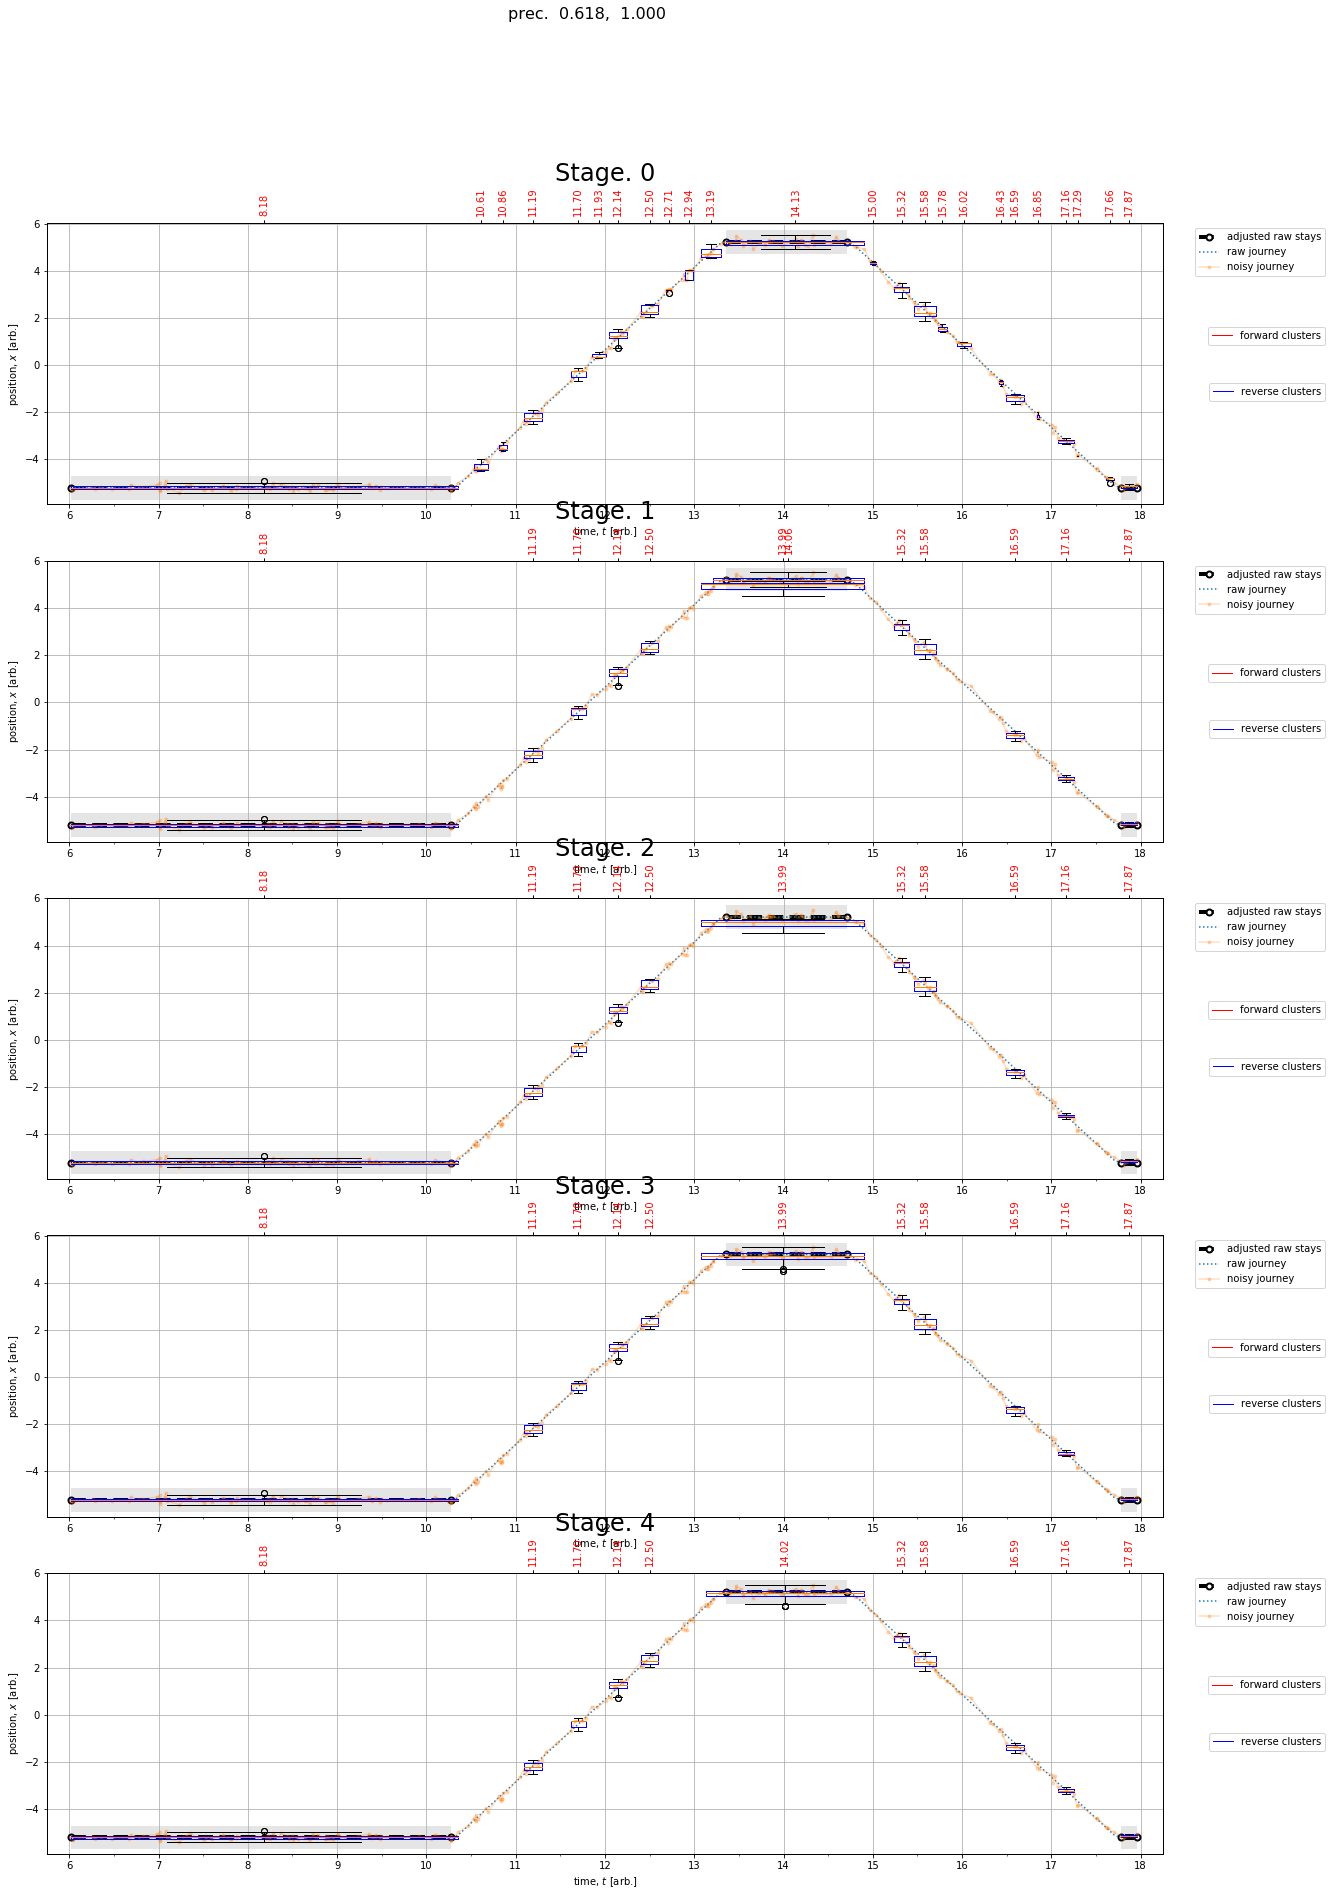

In [635]:
verbose = True
if verbose: print("Stage 1")
clusters_1 = get_clusters_3(t_arr, x_arr, dist_thresh, time_thresh)
if verbose: print(len(clusters_1), "Clusters:")
if verbose: print_clusts(clusters_1);
if verbose: print()

if verbose: print("Stage 2")
clusters_2 = get_extended_clusters(t_arr, x_arr, clusters_1, time_thresh)
if verbose: print(len(clusters_2), "Clusters:")
if verbose: print_clusts(clusters_2);
if verbose: print()

if verbose: print("Stage 3")
#clusters_3 = separate_clusters_hier(clusters_2, True)
if clusters_2 != clusters_1:
    clusters_2 = sorted([sorted(c) for c in clusters_2])    
    #clusters_3 = separate_embedded_clusters(clusters_2)
    clusters_3 = separate_clusters_hier(clusters_2)
    if verbose: print(len(clusters_3), "Clusters:")
    if verbose: print_clusts(clusters_3);
else: 
    if verbose: print("No update")    
    if verbose: clusters_3 = clusters_2.copy()
if verbose: print()    

if verbose: print("Stage 4")
if clusters_3 != clusters_2:
    clusters_3 = sorted([sorted(c) for c in clusters_3])
    clusters_4 = merge_clusters_combo(t_arr, x_arr, clusters_3, dist_thresh, time_thresh)
    if verbose: print(len(clusters_4), "Clusters:")
    if verbose: print_clusts(clusters_4);    
else: 
    if verbose: print("No update")
    clusters_4 = clusters_3.copy()
if verbose: print()

if verbose: print("Stage 5")
clusters_4 = sorted([sorted(c) for c in clusters_4])
clusters_4 = [list(range(c[0],c[-1]+1)) for c in clusters_4]
iqr_trim = True
if iqr_trim:        
    clusters_5 = get_iqr_trimmed_clusters(x_arr, clusters_4, 1.5);
    if verbose: print(len(clusters_5), "Clusters:")
    if verbose: print_clusts(clusters_5);
else: 
    if verbose: print("No IQR-trim")
    clusters_5 = clusters_4.copy()

prec, rec, conmat = eval_synth_data(segments, t_arr, clusters_5)

all_clusters = [
    clusters_1,
    clusters_2,
    clusters_3,
    clusters_4,
    clusters_5    
]

fig, axs = plt.subplots(5,1,figsize=[20,30])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

axs =axs.flatten()

for i in range(5):
    try:
        ax = axs[i]
        add_plot_cluster_boxplots(t_arr, r_arr, x_arr, t_segs, x_segs, all_clusters[i], switch_indices(all_clusters[i], t_arr.shape[0]), configs, ax)
        ax.set_ylim(ylim);
        ax.set_title(f"Stage. {i}", fontsize=24)
    except:
        pass

fig.suptitle(f"prec. {prec:6.3f}, {rec:6.3f}", fontsize=16);

In [578]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev 

def plot_cluster_boxplots_xlim(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters, clusters_rev, configs, xlim=[5.75,18.25]):
    """
    """
    dist_thresh = configs['dist_thresh']
    
    ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh);
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim(xlim)

    bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

    axt = ax.twiny()
    _ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

    for label in axt.get_xticklabels():
        label.set_rotation(90)
    axt.set_xticklabels(labels, visible=True, color='red')


    axt.set_xlim(ax.get_xlim())
    axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


    bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

    axt = ax.twiny()
    labels = list(map(lambda x: f"{x:.2f}", positions))
    _ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
    axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

    for label in axt.get_xticklabels():
        label.set_rotation(90)
        
    axt.set_xticklabels(labels, visible=False)

    axt.set_xlim(ax.get_xlim())
    ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1)
    
    return ax

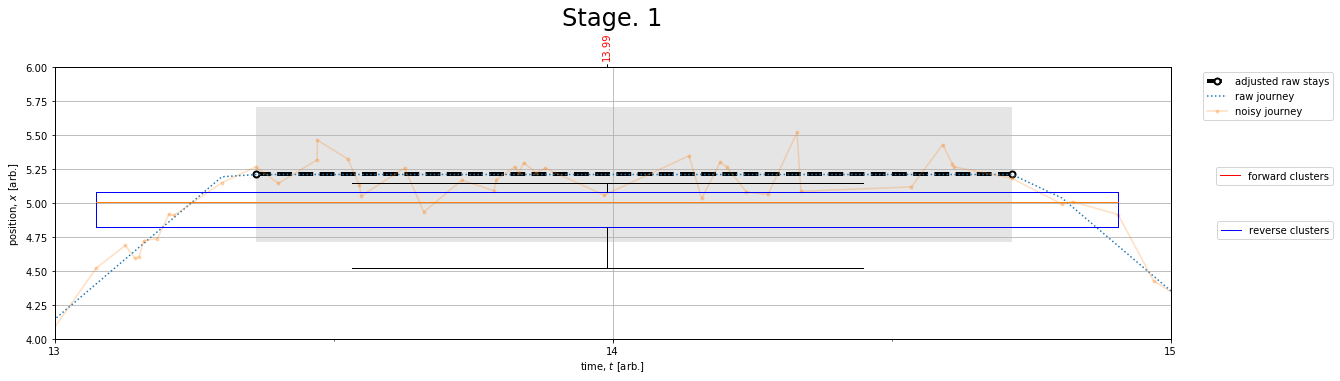

In [579]:
ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]
ax = plot_cluster_boxplots_xlim(t_arr, r_arr, x_arr, t_segs, x_segs, clusters_3, switch_indices(clusters_3, t_arr.shape[0]), configs, [13,15])

ax.set_title("Stage. 1", fontsize=24)

ax.set_ylim(4,6)
ax.set_xlim(13,15);

In [588]:
print_ctimes = lambda cluster_list : [print(f"[{time_arr[c[0]]:6.3f},{time_arr[c[-1]]:6.3f}]") for c in cluster_list]
print_ctimes(clusters_3);

[ 6.009, 9.120]
[ 9.885,10.138]
[10.251,10.501]
[10.826,11.074]
[11.095,11.545]
[14.131,14.356]
[14.447,14.909]
[15.502,15.710]
[16.106,16.245]
[16.689,16.801]
[12.033,13.944]


In [592]:
np.median(x_arr[clusters_3[-1]]), np.mean(x_arr[clusters_3[-1]])

(5.010798728368223, 4.937661698484483)

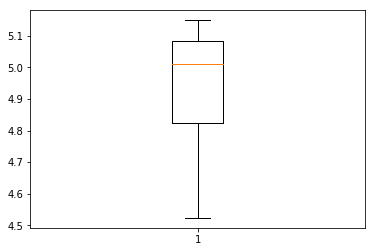

In [596]:
_ = plt.boxplot(x_arr[clusters_3[-1]])

In [612]:
from helper__3stays_v3_scripts import _get_iqr
def get_iqr_mask_xx(sub_arr, offset, iqr_bounds, iqr_fact = 1.5, within=True, verbose=False):
    """
    """
    
    #TODO: rename `x_arr` --> `sub_arr`, `cluster` --> `offset` 
    
    # Mask to include only events within the IQR
    if iqr_bounds != None:
        #if verbose: print("Getting input bounds", iqr_bounds)
        q25, q75 = iqr_bounds
    else:
        q25, q75 = _get_iqr(sub_arr)
    
    iqr = abs(q75 - q25)
        
    print(q25,q75)
    print(q25 - iqr_fact * iqr, q75 + iqr_fact * iqr)
    if within:
        mask = np.where((sub_arr >= (q25 - iqr_fact * iqr)) & (sub_arr <= (q75 + iqr_fact * iqr)))
        
    else:
        mask =  np.where((sub_arr < (q25 - iqr_fact * iqr)) | (sub_arr > (q75 + iqr_fact * iqr)))
    
    mask[0][:] += offset
    
    return mask

In [625]:
clusty = list(range(138,181))

In [626]:
get_iqr_mask_xx(x_arr[clusters_3[-1]], clusters_3[-1][0], None,1.5, True, True)

4.737639051895009 5.0865129373813485
4.2143282236654995 5.609823765610858


(array([138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 158, 159, 160]),)

In [627]:
get_iqr_mask_xx(x_arr[clusty], clusty[0], None,1.5, True, True)

4.992524358132278 5.267424243842208
4.580174529567383 5.679774072407103


(array([139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
        178, 179, 180]),)

In [622]:
mask = np.where((x_arr[clusters_3[-1]] >= 4.2143282236654995) & (x_arr[clusters_3[-1]] <= 5.609823765610858))[0] + clusters_3[-1][0]

In [623]:
mask

array([138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160])

In [619]:
t_arr[clusters_3[-1]], x_arr[clusters_3[-1]]

(array([13.075     , 13.12666667, 13.14388889, 13.15138889, 13.16      ,
        13.18416667, 13.205     , 13.21361111, 13.29972222, 13.40083333,
        13.54638889, 13.54944444, 13.66166667, 13.7875    , 13.985     ,
        14.15972222, 14.24      , 14.27861111, 14.3375    , 14.53555556,
        14.80527778, 14.82444444, 14.90583333]),
 array([4.52310562, 4.68796777, 4.59403622, 4.60470721, 4.7243958 ,
        4.73763905, 4.91807969, 4.90903207, 5.14945145, 5.14503461,
        5.13299891, 5.0522105 , 4.93414792, 5.09130911, 5.05873496,
        5.03386852, 5.08099221, 5.06354451, 5.08651294, 5.11952588,
        4.99252436, 5.01079873, 4.91560103]))

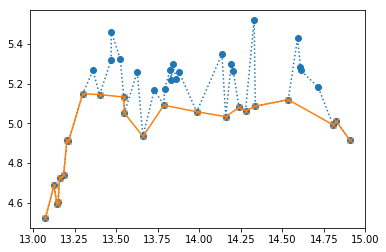

In [633]:
plt.plot(t_arr[clusty], x_arr[clusty], 'o:')
plt.plot(t_arr[clusters_3[-1]], x_arr[clusters_3[-1]], 'x-')

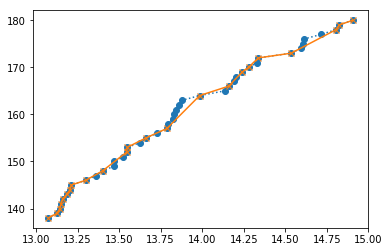

In [632]:
plt.plot(t_arr[clusty], clusty, 'o:')
plt.plot(t_arr[clusters_3[-1]], clusters_3[-1], 'x-')

`get_iqr_mask_x`: min and max are within;
`get_time_ind`: fix moving edge within t-arr;
`get_extended_clusters`: update output

In [620]:
t_arr[mask], x_arr[mask]

(array([13.075     , 13.12666667, 13.14388889, 13.15138889, 13.16      ,
        13.18416667, 13.205     , 13.21361111, 13.29972222, 13.36083333,
        13.40083333, 13.47055556, 13.47111111, 13.52527778, 13.54638889,
        13.54944444, 13.62722222, 13.66166667, 13.72972222, 13.7875    ,
        13.79166667, 13.82472222, 13.83194444]),
 array([4.52310562, 4.68796777, 4.59403622, 4.60470721, 4.7243958 ,
        4.73763905, 4.91807969, 4.90903207, 5.14945145, 5.26691035,
        5.14503461, 5.31874177, 5.46252947, 5.32537888, 5.13299891,
        5.0522105 , 5.25838333, 4.93414792, 5.16852648, 5.09130911,
        5.17240025, 5.26742424, 5.22067039]))

In [624]:
clusters_3[-1]

[138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 148,
 152,
 153,
 155,
 157,
 164,
 166,
 169,
 170,
 172,
 173,
 178,
 179,
 180]

In [561]:
check_clusts = get_extended_clusters(t_arr, x_arr, clusters_1, time_thresh, True);

Cluster #1
	 indices: [   0,   75], length: 76,  bounds: [-5.414, -4.929],  x-width:  0.485 IQR: [   0,   75]
    Backwards
	1.1. [   0,   76], new:    0, last:    0
	1.2. [   0,   75], new:    0, last:    0
	no change break
	1.3. [   0,   75], new:    0, last:    0
    Forwards
	2.1. [   0,  75], new:   82, last:   75
	2.2. [   0,  75], new:   82, last:   75
	no change break

Final clust: length =   76; range = [   0,  75]; working index =   82; duration =  4.338

Cluster #2
	 indices: [  77,   83], length: 7,  bounds: [-4.510, -3.977],  x-width:  0.533 IQR: [  77,   83]
    Backwards
	1.1. [  71,   84], new:   71, last:   77
	1.2. [  77,   83], new:   71, last:   77
	no change break
	1.3. [  77,   83], new:   71, last:   77
    Forwards
	2.1. [  77,  83], new:   90, last:   83
	2.2. [  77,  83], new:   90, last:   83
	no change break
(2)Dropped: 
Final clust: length =    7; range = [  77,  83]; working index =   90; duration =  0.161

Cluster #3
	 indices: [  84,   90], length: 7,  b

## Gap metrics

In [511]:
from helper__gaps import get_intercluster_metrics, get_gap_dist, get_gap_time

In [544]:
def get_gap_metrics(c1, c2, t_arr, x_arr, time_thresh, min_speed=3.6):
    """
    Calculate some metrics for a gap: 
        * the duration of the gap, 
        * the minimal possible duration of the gap to include a stay
        * a location statistic of the gap
    """
    
    # Get the gap indices between adjacent clusters
    gap = list(range(c1[-1],c2[0]+1))
    gap_len = len(gap)
    interstay_dist_medi = abs(np.median(x_arr[c1])-np.median(x_arr[c2]))
    interstay_dist_mean = abs(np.mean(x_arr[c1])-np.mean(x_arr[c2]))
    
    # Returns
    ## Calulate the duration between adjacent clusters
    gap_time = get_gap_time(t_arr,c1,c2)

    ## Calculate the minimal time between two clusters to include two travels and a stay
    dur1 = get_gap_dist(x_arr,c1, gap)/min_speed
    dur2 = get_gap_dist(x_arr,c2, gap)/min_speed
    
    ## Calculate a statistic (ie the median) of the events contained in a gap
    gap_mean   = np.mean(x_arr[gap])
    gap_median = np.median(x_arr[gap])
    '''
    print(f"{gap_len:4d}, {gap_time:6.3f}, {interstay_dist_medi:6.3f}, {interstay_dist_mean:6.3f}, {gap_mean:6.3f}, {gap_median:6.3f}")
    '''
    warning = ""
    if gap_time < time_thresh: 
        warning = "WARNING: too short"
    
    return f"{gap_len:4d}, {gap_time:6.3f}, {interstay_dist_medi:6.3f}, {interstay_dist_mean:6.3f}, {gap_mean:6.3f}, {gap_median:6.3f}  {warning}"

def get_clust_metrics(gap, t_arr, x_arr, time_thresh, min_speed=3.6):
    """
    Calculate some metrics for a gap: 
        * the duration of the gap, 
        * the minimal possible duration of the gap to include a stay
        * a location statistic of the gap
    """
    
    # Get the gap indices between adjacent clusters
    gap_len = len(gap)

    
    # Returns
    ## Calulate the duration between adjacent clusters
    gap_time = t_arr[gap[-1]]-t_arr[gap[0]]

    ## Calculate the minimal time between two clusters to include two travels and a stay
    #dur1 = get_gap_dist(x_arr,c1, gap)/min_speed
    #dur2 = get_gap_dist(x_arr,c2, gap)/min_speed
    
    ## Calculate a statistic (ie the median) of the events contained in a gap
    gap_mean   = np.mean(x_arr[gap])
    gap_median = np.median(x_arr[gap])
    
    return f"{gap_len:4d}, {gap_time:6.3f},   ----,   ----, {gap_mean:6.3f}, {gap_median:6.3f}"

def get_gap_dist(x_arr,c1,c2):
    """
    Gets the spatial difference between two medians of neighboring clusters
    """
    #return get_gap_dist_generic(x_arr[c1], np.median(x_arr[c2]))
    return abs(np.median(x_arr[c1])-np.median(x_arr[c2]))
 

Text(0.5, 1.0, 'Stage. 1')

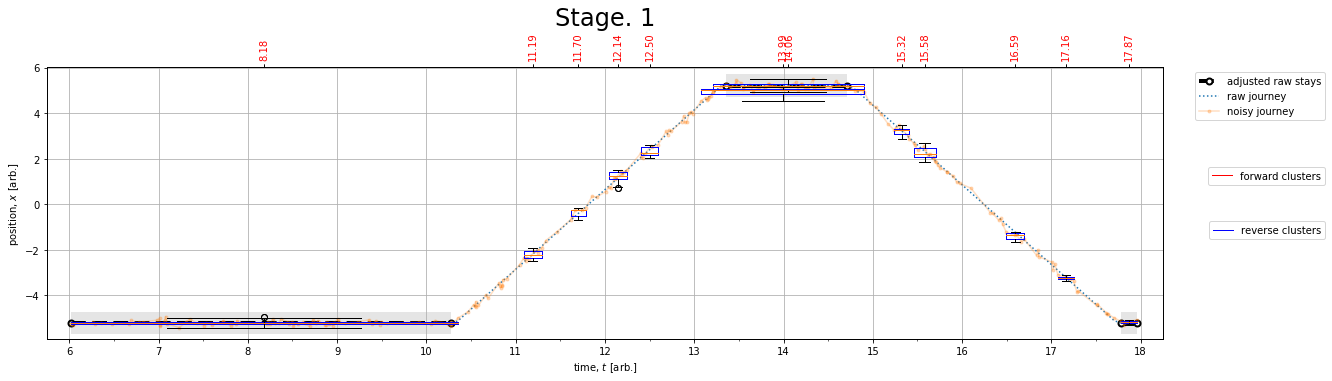

In [567]:
ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]
ax = plot_cluster_boxplots(t_arr, r_arr, x_arr, t_segs, x_segs, clusters_2, switch_indices(clusters_2, t_arr.shape[0]), configs)
ax.set_ylim(ylim);
ax.set_title("Stage. 1", fontsize=24)

In [566]:
print(f"      len,    dur,  dmedi,   dmea,   mean, median")
for n in range(len(clusters_2)):
    if n == 0:
        printstr = get_clust_metrics(clusters_2[n], t_arr, x_arr, time_thresh)
        print(f"{n:4d} {printstr}")
    else:
        printstr = get_gap_metrics(clusters_2[n-1],clusters_2[n], t_arr, x_arr, time_thresh)
        print(f"     {printstr}")
        printstr = get_clust_metrics(clusters_2[n], t_arr, x_arr, time_thresh)
        print(f"{n:4d} {printstr}")


      len,    dur,  dmedi,   dmea,   mean, median
   0   76,  4.338,   ----,   ----, -5.200, -5.207
       18,  0.738,  2.972,  2.983, -3.854, -3.817  
   1    8,  0.202,   ----,   ----, -2.217, -2.236
        4,  0.322,  1.968,  1.843, -1.352, -1.398  
   2    5,  0.171,   ----,   ----, -0.374, -0.268
        5,  0.256,  1.509,  1.569,  0.364,  0.344  
   3   10,  0.205,   ----,   ----,  1.195,  1.241
        2,  0.159,  1.022,  1.130,  1.887,  1.887  WARNING: too short
   4    7,  0.188,   ----,   ----,  2.324,  2.263
       13,  0.481,  2.748,  2.613,  3.584,  3.601  
   5   23,  1.831,   ----,   ----,  4.938,  5.011
        0,  1.701,  0.166,  0.246,    nan,    nan  
   6   36,  1.701,   ----,   ----,  5.184,  5.177
        6,  0.332,  1.896,  1.972,  4.060,  4.112  
   7    6,  0.172,   ----,   ----,  3.212,  3.281
        2,  0.049,  1.052,  0.947,  2.771,  2.771  WARNING: too short
   8   11,  0.247,   ----,   ----,  2.265,  2.228
       15,  0.789,  3.595,  3.668,  0.513,  0.91